<a href="https://colab.research.google.com/github/SolomonM-Kebede/ProjectNLP-DimABSA2026/blob/main/SemVal2026_Task3_ST2%263.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

solomonmengesha_dataset_path = kagglehub.dataset_download('solomonmengesha/dataset')
solomonmengesha_semval1_path = kagglehub.dataset_download('solomonmengesha/semval1')
solomonmengesha_absa_transformers_default_1_path = kagglehub.model_download('solomonmengesha/absa/Transformers/default/1')

print('Data source import complete.')


# SemEval 2026 Task 3 - Kaggle Notebook Version
## Fine-tuning Pipeline for ABSA with VA Prediction

### 1.  Install dependencies

In [ ]:
!pip install --upgrade transformers datasets accelerate sentencepiece
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 95.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 27.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.4.1
    Uninstalling datasets-4.4.1:
      Successfully uninstalled datasets-4.4.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.11.0
    Uninstalling accelerate-1.11.0:
      Successfully uninstalled accelerate-1.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 31.9 MB/s eta 0:00:00:00:0100:01


### 2. Imports and Configuration

In [ ]:
import os, re
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import json, random
import torch

from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.auto import tqdm
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score, mean_squared_error

# Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


E0000 00:00:1768319017.309539      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768319017.378985      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768319017.896036      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768319017.896084      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768319017.896087      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768319017.896090      55 computation_placer.cc:177] computation placer already registered. Please check linka

GPU Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


### 3. Configuration

In [ ]:
class Config:

    # Model
    model_name = "google/flan-t5-base"
    max_source_length = 256
    max_target_length = 256

    # Training - FIXED VALUES
    batch_size = 1
    num_epochs = 6
    learning_rate = 5e-5
    warmup_ratio = 0.1
    gradient_accumulation_steps = 16
    max_grad_norm = 1.0

    # Paths
    train_file = "/kaggle/input/dataset/eng_laptop_train_alltasks.jsonl"
    dev_file = "/kaggle/input/semval1/eng_laptop_dev_task3.jsonl"
    output_dir = "/kaggle/working/absa_model"

    # Task
    task = "subtask3"  # or "subtask2"
    entity_type = "laptop" # or "restaurant"

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Early stopping
    patience = 2  # Stop if no improvement for 3 epochs


    use_gradient_checkpointing = True

config = Config()

os.makedirs(config.output_dir, exist_ok=True)


print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Task: {config.task}")
print(f"  Batch Size: {config.batch_size}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Device: {config.device}")

Configuration:
  Model: google/flan-t5-base
  Task: subtask3
  Batch Size: 1
  Epochs: 6
  Device: cuda


### Mapping

In [ ]:
def normalize_category(category):
    """Fix common typos in TRAINING data categories"""
    if not category or not isinstance(category, str):
        return category

    category = category.strip().upper()

    # Fix common typos
    fixes = {
        "HARD_DISC": "HARD_DISK",
        "HARD DISK": "HARD_DISK",
        "PRICES": "PRICE",
        "OPERATION&PERFORMANCE": "OPERATION_PERFORMANCE",
        "FANS&COOLING": "FANS_COOLING",
        "FANS & COOLING": "FANS_COOLING",
        "FANS_&_COOLING": "FANS_COOLING",
        "MULTIMEDIA DEVICES": "MULTIMEDIA_DEVICES",
        "POWER SUPPLY": "POWER_SUPPLY",
        "DESIGN & FEATURES": "DESIGN_FEATURES",
    }

    for wrong, correct in fixes.items():
        category = category.replace(wrong, correct)

    return category


def validate_category(category, entity_type="laptop"):
    """
    Validate if category is in the allowed list.
    Returns True if valid, False otherwise.
    """
    if not category or "#" not in category:
        return False

    entity, attribute = category.split("#", 1)

    if entity_type.lower() == "laptop":
        valid_entities = ['LAPTOP', 'DISPLAY', 'KEYBOARD', 'MOUSE', 'MOTHERBOARD', 'CPU',
                         'FANS_COOLING', 'PORTS', 'MEMORY', 'POWER_SUPPLY', 'OPTICAL_DRIVES',
                         'BATTERY', 'GRAPHICS', 'HARD_DISK', 'MULTIMEDIA_DEVICES', 'HARDWARE',
                         'SOFTWARE', 'OS', 'WARRANTY', 'SHIPPING', 'SUPPORT', 'COMPANY']
        valid_attributes = ['GENERAL', 'PRICE', 'QUALITY', 'DESIGN_FEATURES',
                           'OPERATION_PERFORMANCE', 'USABILITY', 'PORTABILITY',
                           'CONNECTIVITY', 'MISCELLANEOUS']
    else:  # restaurant
        valid_entities = ['RESTAURANT', 'FOOD', 'DRINKS', 'AMBIENCE', 'SERVICE', 'LOCATION']
        valid_attributes = ['GENERAL', 'PRICES', 'QUALITY', 'STYLE_OPTIONS', 'MISCELLANEOUS']

    return entity in valid_entities and attribute in valid_attributes

def analyze_categories(data, entity_type="laptop"):
    """Analyze category distribution in training data"""
    from collections import Counter

    category_counts = Counter()

    for item in data:
        quads = item.get("Quadruplet", item.get("quadruplets", []))
        for q in quads:
            cat = q.get("Category", "")
            if cat and "#" in cat:
                category_counts[cat] += 1

    print(f"\nTop 20 Categories in {entity_type} data:")
    print("-" * 60)
    for cat, count in category_counts.most_common(20):
        print(f"  {cat:<40} {count:>5}")

    return category_counts

### 7.  Load Data

In [ ]:
print("\n" + "="*80)
print("="*80)

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data


# Load data
print("\nLoading data...")
with open(config.train_file, "r", encoding="utf-8") as f:
    all_data = [json.loads(line) for line in f if line.strip()]

print(f"Total training data: {len(all_data)}")

# Split data - 90% train, 10% test
random.seed(42)
random.shuffle(all_data)

split_idx = int(0.9 * len(all_data))
train_data = all_data[:split_idx]
test_data = all_data[split_idx:]

# Load dev data (unlabeled)
with open(config.dev_file, "r", encoding="utf-8") as f:
    dev_data = [json.loads(line) for line in f if line.strip()]

print(f"Training: {len(train_data)}")
print(f"Test (for metrics): {len(test_data)}")
print(f"Dev (unlabeled, for submission): {len(dev_data)}")

# Show sample
print("\nSample training example:")
print(json.dumps(train_data[0], indent=2, ensure_ascii=False))





Loading data...
Total training data: 4076
Training: 3668
Test (for metrics): 408
Dev (unlabeled, for submission): 200

Sample training example:
{
  "ID": "laptop_quad_train_2127",
  "Text": "picks up wireless signals weakly !",
  "Quadruplet": [
    {
      "Aspect": "wireless signals",
      "Category": "LAPTOP#CONNECTIVITY",
      "Opinion": "weakly",
      "VA": "2.50#7.25"
    }
  ]
}


### 4. Dataset Class

In [ ]:
class ABSADataset(Dataset):
    """
    Dataset that uses gold labels from training data.
    Does NOT filter out NULL values - they're valid!
    """

    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
        self.task = config.task


        # ONLY normalize categories in training data
        self._normalize_categories()

    def _normalize_categories(self):
        """Normalize categories in training data"""
        for item in self.data:
            if self.task == "subtask3":
                quads = item.get("Quadruplet", item.get("quadruplets", []))
                for q in quads:
                    if "Category" in q:
                        q["Category"] = normalize_category(q["Category"])

    def __len__(self):
        return len(self.data)

    def create_input_text(self, item):
        text = item.get("Text", item.get("text", ""))

        # explicitly show the curly braces in the instruction
        if self.task == "subtask2":
            instruction = (
                "Extract aspect-opinion-valence-arousal triplets. "
                "Format: {\"Triplet\": [{\"Aspect\": \"...\", \"Opinion\": \"...\", \"VA\": \"V.VV#A.AA\"}]}\n\n"
                f"Review: {text}"
            )
        else:
            instruction = (
                "Extract aspect-category-opinion-valence-arousal quadruplets. "
                "Format: {\"Quadruplet\": [{\"Aspect\": \"...\", \"Category\": \"...\", \"Opinion\": \"...\", \"VA\": \"V.VV#A.AA\"}]}\n\n"
                f"Review: {text}"
            )
        return instruction

    def create_target_text(self, item):
        gold_data = item.get("Quadruplet", item.get("quadruplets", []))
        if self.task == "subtask2":
            # Strip Category for Subtask 2
            triplets = [{"Aspect": q["Aspect"], "Opinion": q["Opinion"], "VA": q["VA"]} for q in gold_data]
            output = {"Triplet": triplets}
        else:
            output = {"Quadruplet": gold_data}

        # returns the full string starting with { and ending with }
        return json.dumps(output, ensure_ascii=False)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self.create_input_text(item)
        target_text = self.create_target_text(item)

        input_encoding = self.tokenizer(
            input_text,
            max_length=config.max_source_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=config.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels
        }

### 6. Load Model and Tokenizer

In [ ]:
print("\n" + "="*80)
print(f"Loading Model: {config.model_name}")
print("="*80)

tokenizer = T5Tokenizer.from_pretrained(config.model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = T5ForConditionalGeneration.from_pretrained(config.model_name)
model.gradient_checkpointing_enable()
model.to(config.device)

print(f"\nModel loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")



Loading Model: google/flan-t5-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Model loaded successfully!
Model parameters: 247.58M


### 8. Create Datasets and Dataloaders

In [ ]:
print("\n" + "="*80)
print("Creating Datasets...")
print("="*80)



# Create datasets
train_dataset = ABSADataset(train_data, tokenizer, config=config)
test_dataset = ABSADataset(test_data, tokenizer, config=config)
dev_dataset = ABSADataset(dev_data, tokenizer, config=config)
print(f"  Clean training examples: {len(train_dataset)}")
print(f"  Clean test examples: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_dataloader)},Test batches: {len(test_dataloader)}, Dev batches: {len(dev_dataloader)}")

print(f"Training examples: {len(train_dataset)},Test examples:{len(test_dataset)} Dev examples: {len(dev_dataset)}")



Creating Datasets...
  Clean training examples: 3668
  Clean test examples: 408
Train batches: 3668,Test batches: 408, Dev batches: 200
Training examples: 3668,Test examples:408 Dev examples: 200


### 9. Setup Optimizer and Scheduler

In [ ]:
import bitsandbytes as bnb
# Setup optimizer
num_training_steps = len(train_dataloader) * config.num_epochs // config.gradient_accumulation_steps
num_warmup_steps = int(num_training_steps * config.warmup_ratio)

#optimizer = AdamW(model.parameters(), lr=config.learning_rate)
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=config.learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

print(f"\nTraining setup:")
print(f"  Total steps: {num_training_steps}")
print(f"  Warmup steps: {num_warmup_steps}")


Training setup:
  Total steps: 1375
  Warmup steps: 137


### 5. Helper Functions

In [ ]:



def train_epoch(model, dataloader, optimizer, scheduler, device, config, tokenizer):
    model.train()
    # Stability: If using gradient checkpointing, use_cache MUST be False
    if config.use_gradient_checkpointing:
        model.config.use_cache = False

    total_loss = 0.0
    step_losses = []

    progress_bar = tqdm(dataloader, desc="Training")

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # DATA INTEGRITY CHECK (First step only)
        if step == 0:
            print(f"\n[DEBUG] Input sample: {tokenizer.decode(input_ids[0], skip_special_tokens=True)}")
            check_labels = labels[0].clone()
            check_labels[check_labels == -100] = tokenizer.pad_token_id
            print(f"[DEBUG] Label sample: {tokenizer.decode(check_labels, skip_special_tokens=True)}")

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # FIX: Handle cases where outputs might be a ModelOutput object, a dict, or a raw Tensor
        if hasattr(outputs, 'loss'):
            loss = outputs.loss
        elif isinstance(outputs, dict):
            loss = outputs['loss']
        else:
            # If it's a raw tensor (common with some checkpointing wrappers)
            loss = outputs

        # Normalize loss for gradient accumulation
        loss = loss / config.gradient_accumulation_steps
        loss.backward()

        current_loss_val = loss.item() * config.gradient_accumulation_steps
        step_losses.append(current_loss_val)

        # Optimizer step
        if (step + 1) % config.gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += current_loss_val
        progress_bar.set_postfix({'loss': f"{current_loss_val:.2e}"})

    return total_loss / len(dataloader), step_losses

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    # Ensure cache is enabled for faster evaluation (only disable for training)
    model.config.use_cache = True

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", ncols=100):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Use the same robust loss extraction as train_epoch
            if hasattr(outputs, 'loss'):
                loss_val = outputs.loss.item()
            elif isinstance(outputs, dict):
                loss_val = outputs['loss'].item()
            else:
                loss_val = outputs.item()

            total_loss += loss_val
            num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

def generate_sample_predictions(model, tokenizer, dataloader, device, num_samples=5):
    model.eval()
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            input_ids = batch["input_ids"][:1].to(device)
            attention_mask = batch["attention_mask"][:1].to(device)
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                     max_length=config.max_target_length, num_beams=4, early_stopping=True)
            pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
            samples.append(pred)
    return samples

def is_valid_element(item, field):
    """Check if element is valid (not NULL or empty)"""
    value = item.get(field, "")
    if not value:
        return False
    value_str = str(value).strip().upper()
    return value_str not in ["NULL", "NONE", ""]


def compute_f1(pred_list, gold_list, include_category=False):
    def to_tuple(item, include_cat):
        asp = str(item.get("Aspect", "NULL")).strip().lower()
        op  = str(item.get("Opinion", "NULL")).strip().lower()

        if include_cat:
            # Subtask 3 logic
            cat = str(item.get("Category", "LAPTOP#GENERAL")).strip().lower()
            return (asp, cat, op)

        # Subtask 2 logic (ignores category even if present in the dict)
        return (asp, op)

    pred_set = set([to_tuple(p, include_category) for p in pred_list])
    gold_set = set([to_tuple(g, include_category) for g in gold_list])

    if not gold_set and not pred_set: return 1.0, 1.0, 1.0
    if not gold_set or not pred_set: return 0.0, 0.0, 0.0

    tp = len(pred_set & gold_set)
    precision = tp / len(pred_set) if len(pred_set) > 0 else 0.0
    recall = tp / len(gold_set) if len(gold_set) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1, precision, recall

def compute_rmse(pred_va, gold_va):
    pred_vals, gold_vals = [], []

    for p, g in zip(pred_va, gold_va):
        if p == "NULL" or g == "NULL" or "#" not in str(p) or "#" not in str(g):
            continue
        try:
            p_v, p_a = map(float, p.split("#"))
            g_v, g_a = map(float, g.split("#"))
            pred_vals.append([p_v, p_a])
            gold_vals.append([g_v, g_a])
        except:
            continue

    if not pred_vals:
        return np.nan, np.nan

    pred_vals = np.array(pred_vals)
    gold_vals = np.array(gold_vals)

    try:
        # Try the modern way first (scikit-learn 1.4+)
        from sklearn.metrics import root_mean_squared_error
        rmse_v = root_mean_squared_error(gold_vals[:, 0], pred_vals[:, 0])
        rmse_a = root_mean_squared_error(gold_vals[:, 1], pred_vals[:, 1])
    except ImportError:
        # Fallback for older versions
        rmse_v = mean_squared_error(gold_vals[:, 0], pred_vals[:, 0], squared=False)
        rmse_a = mean_squared_error(gold_vals[:, 1], pred_vals[:, 1], squared=False)

    return rmse_v, rmse_a

def compute_ccc(pred_va, gold_va):
    """Compute Concordance Correlation Coefficient"""
    def ccc_single(x, y):
        x = np.array(x)
        y = np.array(y)
        if len(x) < 2:
            return float("nan")
        mean_x, mean_y = np.mean(x), np.mean(y)
        cov = np.mean((x - mean_x) * (y - mean_y))
        var_x, var_y = np.var(x), np.var(y)
        return 2 * cov / (var_x + var_y + (mean_x - mean_y)**2 + 1e-8)

    pred_vals, gold_vals = [], []

    for p, g in zip(pred_va, gold_va):
        if not p or not g:
            continue
        p_str = str(p).strip().upper()
        g_str = str(g).strip().upper()
        if p_str == "NULL" or g_str == "NULL":
            continue

        try:
            p_parts = str(p).split("#")
            g_parts = str(g).split("#")
            if len(p_parts) == 2 and len(g_parts) == 2:
                pred_vals.append([float(p_parts[0]), float(p_parts[1])])
                gold_vals.append([float(g_parts[0]), float(g_parts[1])])
        except:
            continue

    if not pred_vals or not gold_vals or len(pred_vals) < 2:
        return float("nan"), float("nan")

    pred_vals = np.array(pred_vals)
    gold_vals = np.array(gold_vals)

    ccc_v = ccc_single(pred_vals[:, 0], gold_vals[:, 0])
    ccc_a = ccc_single(pred_vals[:, 1], gold_vals[:, 1])

    return ccc_v, ccc_a





### 10. Training Loop

In [ ]:
import re
import numpy as np
import torch
from tqdm import tqdm

print("\n" + "="*80)
print(f"Starting Training: {config.task.upper()}")
print("="*80)

# Stability: Disable cache for training when using gradient checkpointing
if config.use_gradient_checkpointing:
    model.config.use_cache = False

best_f1 = -1.0
patience_counter = 0

training_history = {
    "train_loss_epoch": [],
    "test_loss_epoch": [],
    "test_f1": [],
    "all_step_losses": [],
    "best_epoch": 0
}

# Determine metric names based on config
is_subtask3 = (config.task == "subtask3")
metric_label = "Full Quad (A+C+O)" if is_subtask3 else "Triplet (A+O)"

for epoch in range(config.num_epochs):
    print(f"\n{'='*20} Epoch {epoch + 1}/{config.num_epochs} {'='*20}")

    # 1. TRAINING PHASE
    avg_loss, step_losses = train_epoch(
        model, train_dataloader, optimizer, scheduler, config.device, config, tokenizer
    )
    training_history["train_loss_epoch"].append(avg_loss)
    training_history["all_step_losses"].extend(step_losses) # Collect for spectrum

    # 2. EVALUATION PHASE
    test_loss = evaluate(model, test_dataloader, config.device)
    training_history["test_loss_epoch"].append(test_loss)


    # 3. METRICS GENERATION PHASE
    print("-" * 30)
    print(f"Evaluating {metric_label} Performance...")

    all_f1_scores = []
    parse_success, parse_fail = 0, 0

    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_dataloader, desc="Predicting")):
            input_ids = batch["input_ids"].to(config.device)
            attention_mask = batch["attention_mask"].to(config.device)

            # Optimized generation settings
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=config.max_target_length,
                num_beams=2,
                repetition_penalty=1.2,
                do_sample=False,
                early_stopping=True
            )

            batch_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for i, pred_text in enumerate(batch_predictions):
                idx = batch_idx * config.batch_size + i
                if idx >= len(test_data): break

                # Debug first sample of the epoch
                if batch_idx == 0 and i == 0:
                    print(f"\n[DEBUG] Raw Model Output: {pred_text}")

                # DYNAMIC PARSER: Extracts all available fields
                pred_list = []
                asps = re.findall(r'"Aspect"\s*:\s*"([^"]*)"', pred_text)
                ops  = re.findall(r'"Opinion"\s*:\s*"([^"]*)"', pred_text)
                vas  = re.findall(r'"VA"\s*:\s*"([^"]*)"', pred_text)
                cats = re.findall(r'"Category"\s*:\s*"([^"]*)"', pred_text)

                for j in range(len(asps)):
                    entry = {
                        "Aspect": asps[j],
                        "Opinion": ops[j] if j < len(ops) else "NULL",
                        "VA": vas[j] if j < len(vas) else "5.00#5.00"
                    }
                    # Always capture category if predicted, compute_f1 will filter if needed
                    if is_subtask3 or len(cats) > 0:
                        entry["Category"] = cats[j] if j < len(cats) else "LAPTOP#GENERAL"
                    pred_list.append(entry)

                if pred_list: parse_success += 1
                else: parse_fail += 1

                # GET GOLD LABELS
                gold_item = test_data[idx]
                gold_key = "Quadruplet" if "Quadruplet" in gold_item else "Triplet"
                gold_list = gold_item.get(gold_key, [])

                # COMPUTE F1: include_category is driven by config
                f1, _, _ = compute_f1(pred_list, gold_list, include_category=is_subtask3)
                all_f1_scores.append(f1)


    # 4. EPOCH SUMMARY & CHECKPOINTINg
    current_mean_f1 = np.mean(all_f1_scores) if all_f1_scores else 0.0
    training_history["test_f1"].append(current_mean_f1)

    print(f"\nParsing Summary: Success={parse_success}, Failed={parse_fail}")
    print(f"Mean {metric_label} F1: {current_mean_f1:.4f}")

    if current_mean_f1 > best_f1:
        best_f1 = current_mean_f1
        training_history["best_epoch"] = epoch + 1
        patience_counter = 0
        print(f"s SAVING BEST MODEL (F1: {best_f1:.4f})")
        model.save_pretrained(config.output_dir)
        tokenizer.save_pretrained(config.output_dir)
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{config.patience}")

    if patience_counter >= config.patience:
        print("\nEarly stopping triggered. Ending training.")
        break

print("\n" + "="*80)
print(f"Training Complete! Best {metric_label} F1: {best_f1:.4f} at Epoch {training_history['best_epoch']}")
print("="*80)


Starting Training: SUBTASK3

==================== Epoch 1/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: has everything i was looking for , such as touch screen capability , tablet convertible , small bezel , lightweight and small footprint , * backlit * keyboard , not one but two * * usb - c * * ports , octane 2 .
[DEBUG] Label sample: "Quadruplet": ["Aspect": "touch screen capability", "Category": "KEYBOARD#GENERAL", "Opinion": "NULL", "VA": "5.00#5.00", "Aspect": "tablet", "Category": "LAPTOP#DESIGN_FEATURES", "Opinion": "convertible", "VA": "7.50#7.75", "Aspect": "bezel", "Category": "LAPTOP#DESIGN_FEATURES", "Opinion": "small", "VA": "6.75#7.00", "Aspect": "footprint", "Category": "LAPTOP#DESIGN_FEATURES", "Opinion": "lightweight", "VA": "7.50#7.75", "Aspect": "footprint", "Category": "LAPTOP#DESIGN_FEATURES", "Opinion":


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.04it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<13:21,  1.97s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "7.00#7.00"]


Predicting: 100%|██████████| 408/408 [09:26<00:00,  1.39s/it]



Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.1178
s SAVING BEST MODEL (F1: 0.1178)

==================== Epoch 2/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: my only other complaint is trackpad sensitivity .
[DEBUG] Label sample: "Quadruplet": ["Aspect": "trackpad sensitivity", "Category": "HARDWARE#OPERATION_PERFORMANCE", "Opinion": "complaint", "VA": "3.38#6.75"]


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.02it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<09:25,  1.39s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.50"]


Predicting: 100%|██████████| 408/408 [10:11<00:00,  1.50s/it]



Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.2665
s SAVING BEST MODEL (F1: 0.2665)

==================== Epoch 3/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: i can not leave now because i need my computer fixed .
[DEBUG] Label sample: "Quadruplet": ["Aspect": "computer", "Category": "LAPTOP#GENERAL", "Opinion": "NULL", "VA": "5.00#5.00"]


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.23it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<08:41,  1.28s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.50"]


Predicting: 100%|██████████| 408/408 [11:28<00:00,  1.69s/it]



Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.3365
s SAVING BEST MODEL (F1: 0.3365)

==================== Epoch 4/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: my only issue is the wifi likes to randomly turn off then back on .
[DEBUG] Label sample: "Quadruplet": ["Aspect": "wifi", "Category": "PORTS#CONNECTIVITY", "Opinion": "NULL", "VA": "4.50#5.25"]


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.01it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<09:09,  1.35s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.12"]


Predicting: 100%|██████████| 408/408 [11:20<00:00,  1.67s/it]



Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.3593
s SAVING BEST MODEL (F1: 0.3593)

==================== Epoch 5/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: screen maximum brightness is still not bright enough
[DEBUG] Label sample: "Quadruplet": ["Aspect": "screen", "Category": "DISPLAY#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "5.00#4.88"]


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 19.02it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<09:52,  1.46s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.12"]


Predicting: 100%|██████████| 408/408 [11:15<00:00,  1.65s/it]



Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.3696
s SAVING BEST MODEL (F1: 0.3696)

==================== Epoch 6/6 ====================


Training:   0%|          | 0/3668 [00:00<?, ?it/s]


[DEBUG] Input sample: Extract aspect-category-opinion-valence-arousal quadruplets. Format: "Quadruplet": ["Aspect": "...", "Category": "...", "Opinion": "...", "VA": "V.VV#A.AA"] Review: nothing on it feels cheap at all .
[DEBUG] Label sample: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#DESIGN_FEATURES", "Opinion": "NULL", "VA": "5.00#5.00"]


Evaluating: 100%|█████████████████████████████████████████████████| 408/408 [00:21<00:00, 18.98it/s]


------------------------------
Evaluating Full Quad (A+C+O) Performance...


Predicting:   0%|          | 1/408 [00:01<09:02,  1.33s/it]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.12"]


Predicting: 100%|██████████| 408/408 [11:28<00:00,  1.69s/it]


Parsing Summary: Success=408, Failed=0
Mean Full Quad (A+C+O) F1: 0.3665
No improvement. Patience: 1/2

Training Complete! Best Full Quad (A+C+O) F1: 0.3696 at Epoch 5


In [ ]:
with open('/kaggle/working/t5_base_history.json', 'w') as f:
    json.dump(training_history, f)

### 11. Plot Training Curves

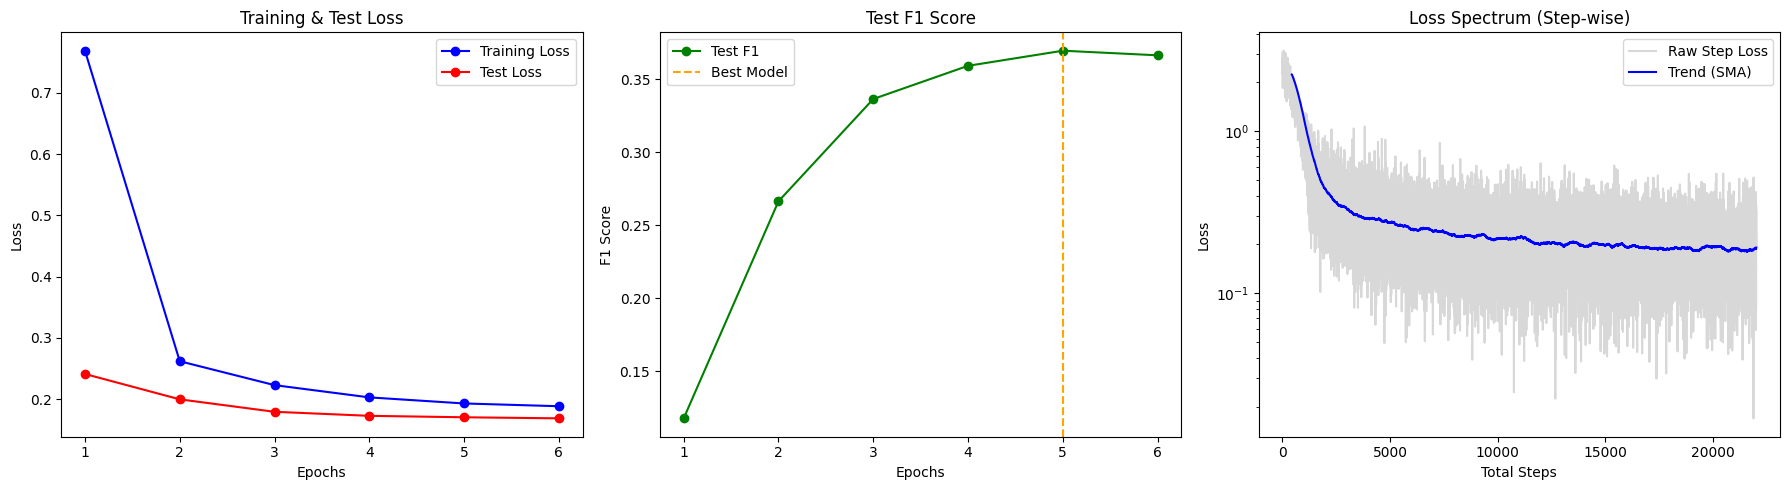

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_training_results(history):
    epochs = range(1, len(history["train_loss_epoch"]) + 1)

    plt.figure(figsize=(18, 5))

    # Plot 1: Epoch-wise Loss (Train vs Test)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss_epoch"], 'bo-', label='Training Loss')
    plt.plot(epochs, history["test_loss_epoch"], 'ro-', label='Test Loss')
    plt.title('Training & Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot 2: F1 Score Trend
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["test_f1"], 'go-', label='Test F1')
    plt.axvline(history["best_epoch"], color='orange', linestyle='--', label='Best Model')
    plt.title('Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot 3: Loss "Spectrum" (Step-wise Loss)
    plt.subplot(1, 3, 3)
    steps = range(len(history["all_step_losses"]))
    plt.plot(steps, history["all_step_losses"], alpha=0.3, color='gray', label='Raw Step Loss')
    # Add a moving average to see the "signal" through the noise
    window = max(1, len(steps) // 50)
    smooth_loss = np.convolve(history["all_step_losses"], np.ones(window)/window, mode='valid')
    plt.plot(steps[window-1:], smooth_loss, color='blue', label='Trend (SMA)')
    plt.title('Loss Spectrum (Step-wise)')
    plt.xlabel('Total Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_training_results(training_history)


### 12. Generate Predictions on Dev Set

In [ ]:
import re
import json
import torch
from tqdm import tqdm

print("\n" + "="*80)
print("Generating Final Predictions (Standardized Format)")
print("="*80)

def apply_domain_guard(item, config):
    """Refined helper to ensure high-precision category mapping based on config."""
    # Only applies to Subtask 3
    if "Category" not in item:
        return item

    cat = item.get("Category", "").upper()
    asp = item.get("Aspect", "").lower()

    # Identify domains based on config
    is_restaurant = config.entity_type.lower() == "restaurant"
    forbidden = "LAPTOP" if is_restaurant else "RESTAURANT"

    # Check for cross-domain leakage
    if forbidden in cat or not cat:
        if is_restaurant:
            # Smart remapping for Restaurant
            mapping = {
                "SERVICE#GENERAL": ['service', 'staff', 'waiter', 'server', 'owner', 'management'],
                "FOOD#QUALITY": ['food', 'dish', 'sauce', 'meat', 'taste', 'flavor', 'cheese', 'pizza'],
                "FOOD#PRICE": ['price', 'cost', 'bill', 'expensive', 'cheap'],
                "DRINKS#QUALITY": ['drink', 'wine', 'beer', 'coffee', 'bar', 'cocktail', 'soda'],
                "AMBIENCE#GENERAL": ['atmosphere', 'decor', 'music', 'vibe', 'clean', 'bathroom']
            }
        else:
            # Default mapping for Laptop if needed
            mapping = {"LAPTOP#GENERAL": ['laptop', 'computer', 'screen', 'battery', 'software']}

        for target_cat, keywords in mapping.items():
            if any(k in asp for k in keywords):
                item["Category"] = target_cat
                return item

        # Final fallback if no keywords match
        item["Category"] = "FOOD#QUALITY" if is_restaurant else "LAPTOP#GENERAL"

    return item

def normalize_case(item, task):
    """
    Normalize case for aspects and opinions (lowercase),
    while keeping categories uppercase.

    Args:
        item: Dictionary containing Aspect, Opinion, VA, and optionally Category
        task: "subtask2" or "subtask3"

    Returns:
        Normalized item
    """
    normalized = {}

    # Aspect: lowercase
    if "Aspect" in item:
        aspect = str(item["Aspect"]).strip()
        # Keep "NULL" uppercase, lowercase everything else
        normalized["Aspect"] = aspect if aspect.upper() == "NULL" else aspect.lower()

    # Category: UPPERCASE (only for subtask3)
    if task == "subtask3" and "Category" in item:
        category = str(item["Category"]).strip().upper()
        normalized["Category"] = category

    # Opinion: lowercase
    if "Opinion" in item:
        opinion = str(item["Opinion"]).strip()
        # Keep "NULL" uppercase, lowercase everything else
        normalized["Opinion"] = opinion if opinion.upper() == "NULL" else opinion.lower()

    # VA: keep as-is (numeric)
    if "VA" in item:
        normalized["VA"] = str(item["VA"]).strip()

    return normalized

# Load best model
best_model = T5ForConditionalGeneration.from_pretrained(config.output_dir).to(config.device)
best_model.eval()

processed_predictions = []

def extract_prediction(text, task, config):
    """
    Dynamic extraction that protects against cross-domain leakage
    without overwriting valid specific categories.
    """
    norm_text = text.replace("'", '"')

    # Identify the "Forbidden" domain
    forbidden_domain = "LAPTOP" if config.entity_type.lower() == "restaurant" else "RESTAURANT"
    default_cat = "FOOD#QUALITY" if config.entity_type.lower() == "restaurant" else "LAPTOP#GENERAL"

    # strict JSON parsing
    try:
        start = text.find('{')
        end = text.rfind('}') + 1
        if start != -1 and end != 0:
            parsed = json.loads(text[start:end])
            key = "Triplet" if task == "subtask2" else "Quadruplet"
            if key in parsed:
                raw_data = parsed[key]
                # Apply domain guard to JSON results too
                for item in raw_data:
                    if "Category" in item and forbidden_domain in item["Category"].upper():
                        item["Category"] = default_cat
                    # Apply case normalization
                    item.update(normalize_case(item, task))
                return raw_data
    except:
        pass

    # Robust Regex Fallback
    aspects = re.findall(r'"?Aspect"?\s*:\s*"([^"]*)"', norm_text)
    opinions = re.findall(r'"?Opinion"?\s*:\s*"([^"]*)"', norm_text)
    va_scores = re.findall(r'"?VA"?\s*:\s*"([^"]*)"', norm_text)

    result = []
    if task == "subtask3":
        categories = re.findall(r'"?Category"?\s*:\s*"([^"]*)"', norm_text)
        for i in range(len(aspects)):
            raw_cat = categories[i] if i < len(categories) else default_cat

            # Create the initial object
            obj = {
                "Aspect": aspects[i],
                "Category": raw_cat,
                "Opinion": opinions[i] if i < len(opinions) else "NULL",
                "VA": va_scores[i] if i < len(va_scores) else "5.00#5.00"
            }

            # --- APPLY DOMAIN GUARD HERE ---
            obj = apply_domain_guard(obj, config)

            # --- APPLY CASE NORMALIZATION HERE ---
            obj = normalize_case(obj, task)

            result.append(obj)
    else: # Subtask 2
        for i in range(len(aspects)):
            obj = {
                "Aspect": aspects[i],
                "Opinion": opinions[i] if i < len(opinions) else "NULL",
                "VA": va_scores[i] if i < len(va_scores) else "5.00#5.00"
            }

            # --- APPLY CASE NORMALIZATION HERE ---
            obj = normalize_case(obj, task)

            result.append(obj)

    # Clean up NULL entries (case-insensitive check)
    cleaned_result = [
        item for item in result
        if not (item.get("Aspect", "").upper() == "NULL" and
                item.get("Opinion", "").upper() == "NULL")
    ]

    return cleaned_result

# --- inference loop ---
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dev_dataloader, desc="Inference", ncols=100)):
        input_ids = batch["input_ids"].to(config.device)
        attention_mask = batch["attention_mask"].to(config.device)

        outputs = best_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=config.max_target_length,
            num_beams=4,
            length_penalty=1.5,
            repetition_penalty=1.0,
            no_repeat_ngram_size=0,
            early_stopping=True
        )

        batch_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for i, pred_text in enumerate(batch_predictions):
            idx = batch_idx * config.batch_size + i
            if idx >= len(dev_data): break

            res_id = dev_data[idx].get("ID", dev_data[idx].get("id", str(idx)))

            # This logic puts the ID and the list into the EXACT required JSON structure
            key = "Triplet" if config.task == "subtask2" else "Quadruplet"
            extracted_data = extract_prediction(pred_text, config.task, config)

            # Create a dictionary in the exact format: {"ID": "...", "Triplet": [...]}
            final_json_obj = {
                "ID": res_id,
                key: extracted_data
            }
            processed_predictions.append(final_json_obj)

# --- Save JSONL ---
output_file = "/kaggle/working/final_submission.jsonl"
with open(output_file, "w", encoding="utf-8") as f:
    for res in processed_predictions:
        # ensure_ascii=False keeps the text readable
        f.write(json.dumps(res, ensure_ascii=False) + "\n")

print(f"\n SUCCESS: Saved {len(processed_predictions)} lines to {output_file}")

# Display samples
print("\n" + "="*80)
print("Sample Outputs")
print("="*80)

for i in range(min(3, len(processed_predictions))):
    print(f"\nSample {i+1}:")
    print(json.dumps(processed_predictions[i], ensure_ascii=False, indent=2))

print("\n" + "="*80)


Generating Final Predictions (Standardized Format)


Inference: 100%|██████████████████████████████████████████████████| 200/200 [06:04<00:00,  1.82s/it]


 SUCCESS: Saved 200 lines to /kaggle/working/final_submission.jsonl

Sample Outputs

Sample 1:
{
  "ID": "lap26_asqp_dev_1",
  "Quadruplet": [
    {
      "Aspect": "perforemce",
      "Category": "LAPTOP#PRICE",
      "Opinion": "great",
      "VA": "7.50#7.50"
    }
  ]
}

Sample 2:
{
  "ID": "lap26_asqp_dev_2",
  "Quadruplet": [
    {
      "Aspect": "display",
      "Category": "DISPLAY#DESIGN_FEATURES",
      "Opinion": "very bright",
      "VA": "7.50#7.50"
    },
    {
      "Aspect": "color gamut",
      "Category": "DISPLAY#DESIGN_FEATURES",
      "Opinion": "wide",
      "VA": "7.50#7.50"
    }
  ]
}

Sample 3:
{
  "ID": "lap26_asqp_dev_3",
  "Quadruplet": [
    {
      "Aspect": "battery life",
      "Category": "BATTERY#OPERATION_PERFORMANCE",
      "Opinion": "bad",
      "VA": "2.50#7.50"
    }
  ]
}



### 13. Download Model

In [ ]:
print("\n" + "="*80)
print("Preparing Model for Download")
print("="*80)

# Create a zip file of the model
import shutil

zip_path = "/kaggle/working/absa_model"
shutil.make_archive(zip_path, 'zip', config.output_dir)

print(f"Model archived!")
print(f"\nTo download your trained model:")
print(f"  1. Look in the right sidebar under 'Output'")
print(f"  2. Download 'absa_model.zip'")
print(f"  3. Extract and use with inference script")

print("\n" + "="*80)
print("All Done!")
print("="*80)
print("\nNext steps:")
print("  1. Download absa_model.zip from Output")
print("  2. Use the inference script to make predictions")
print("  3. Evaluate on test set")



Preparing Model for Download
Model archived!

To download your trained model:
  1. Look in the right sidebar under 'Output'
  2. Download 'absa_model.zip'
  3. Extract and use with inference script

All Done!

Next steps:
  1. Download absa_model.zip from Output
  2. Use the inference script to make predictions
  3. Evaluate on test set
